In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [187]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 'full'
pdgId = 13
category = 0
OLD_CTAU = 100 #cm
ntupler_version = 'V1p12/'
analyzer_version = 'v4/v5/'

ntupler_version = 'V1p14/'
analyzer_version = 'v1/v1/' 
ntupler_version = 'V1p15/'
analyzer_version = 'v3/v4/' # no MET cut applied
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_RunIIFall18/'+analyzer_version+'/normalized/'
# fpath_bkg['ctau1'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_1pb_weighted.root'

ntupler_version = 'V1p15/'
analyzer_version = 'v3/v3/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
fpath_bkg['ggh18'] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'

fpath_bkg['vbfh18'] = mc_path + 'VBFH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
# fpath_bkg['bkg'] = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/signal_oot.root'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p9/MC_Summer16/v1/v3/normalized/'

# fpath_bkg['qcd_bkg'] = mc_path + 'QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall17/'+analyzer_version+'/normalized/'
# fpath_bkg['17'] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Summer16/'+analyzer_version+'/normalized/'
# fpath_bkg['16'] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

# fpath_bkg['vbf18'] = mc_path + 'VBFH_HToSSTobbbb_MH-125_MS-55_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'

lumi = 137000


NEvents = {}
print(data_year, lumi/1000)
NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
   
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
#     print("NEvents_genweight",NEvents_genweight[k])


#     print ('weights',np.unique(a)*lumi)
#     print(np.sum(a)*lumi)
#     print(len(a))



full 137.0
ggh18 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15//MC_Fall18/v3/v3//normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
NEvents 46660160.0
vbfh18 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15//MC_Fall18/v3/v3//normalized/VBFH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
NEvents 384300.47


# Load trigger

In [188]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# load bdt

In [189]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
model = pickle.load(open( bdt_name+'.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
print (y_pred)


[0.24800783]


In [190]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

In [36]:
T = tree_bkg['mc']
nev = len(T.array('gLLP_csc'))
acc = np.sum(T.array('gLLP_csc'),axis = 1)>0
print(acc.shape)
print('acceptance',np.count_nonzero(np.sum(T.array('gLLP_csc'),axis = 1)>0)/nev)
print('met cut wrt all evt',np.count_nonzero(T.array('met')>200)/nev)
print('met cut wrt acc',np.count_nonzero(np.logical_and(acc, T.array('met')>200))/np.count_nonzero(acc))
print('met trigger wrt acc',np.count_nonzero(np.logical_and(acc, T.array('HLTDecision')[:,310]))/np.count_nonzero(acc))

weight = T.array('weight')
nev = np.sum(weight)

cond_dt =np.abs(T.array('gLLP_decay_vertex_z')) < 650
cond_dt = np.logical_and(cond_dt, T.array('gLLP_decay_vertex_r') < 740)
cond_dt = np.logical_and(cond_dt, T.array('gLLP_decay_vertex_r') > 440)
cond_dt = np.sum(cond_dt, axis = 1) > 0

    
print('acceptance',np.sum(weight[np.sum(T.array('gLLP_csc'),axis = 1)>0])/nev)
print('met cut wrt all evt',np.sum(weight[T.array('met')>200])/nev)
print('met cut wrt acc',np.sum(weight[np.logical_and(acc, T.array('met')>200)])/np.sum(weight[acc]))
print('met trigger wrt acc',np.sum(weight[np.logical_and(acc, T.array('HLTDecision')[:,310])])/np.sum(weight[acc]))

print('acceptance',np.sum(weight[cond_dt])/nev)
print('met cut wrt all evt',np.sum(weight[T.array('met')>200])/nev)
print('met cut wrt acc',np.sum(weight[np.logical_and(cond_dt, T.array('met')>200)])/np.sum(weight[cond_dt]))
print('met trigger wrt acc',np.sum(weight[np.logical_and(cond_dt, T.array('HLTDecision')[:,310])])/np.sum(weight[cond_dt]))


KeyError: 'mc'

# nCsc with different hit vetoing

In [213]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False


# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# bdtBkgEff =  0.10278372591006424
if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
    BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
    bdtBkgEff = 0.09957173447537473
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
    BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.06745182012847965
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
    BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.061027837259100645
else:
    print('BDT NAME NOT FOUND')

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_match_gLLP_index = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}

bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
gHiggsPt = {}
gLLP_pt = {}
gLLP2_pt = {}
gLLP2_decay_vertex_r = {}
gLLP2_decay_vertex_z = {}
gLLP_e  = {}
gLLP_pt  = {}
gLLP_eta  = {}
gLLP_m  = {}
weight_nocut = {}
gParticleId = {}
gParticlePt = {}
# keys = ['mc_sr']
weight_nocut = {}
ncluster = 1
for k, T in tree_bkg.items():
        
    print(k)
    if 'qcd' in k:continue
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    
    sel_ev[k] = np.sum(T.array('gLLP_csc'),axis = 1) >= 0
    
    sel_ev[k]   = np.logical_and(sel_ev[k] ,hlt[:,310])

    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
#     print('met eff', np.sum(T.array('weight')[sel_ev[k]]*T.array('pileupWeight')[sel_ev[k]])/np.sum(T.array('weight')*T.array('pileupWeight')))
    sel_ev[k]  = np.logical_and(sel_ev[k] ,T.array('category') >= category)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] ,sel_jet.sum()>=1)
    print('evt sel', np.sum(T.array('weight')[sel_ev[k]]*T.array('pileupWeight')[sel_ev[k]])/np.sum(T.array('weight')*T.array('pileupWeight')))


    ########### SELECTION: CLUSTERS ############

#     sel_rechitcluster = np.logical_and(T.array('cscRechitClusterTime') < 12.5, T.array('cscRechitClusterTime') > -5.0) 
#     cond = np.logical_and(sel_ev[k],sel_rechitcluster.sum() > 0)
#     print('time cut', np.sum(T.array('weight')[cond]*T.array('pileupWeight')[cond])/np.sum(T.array('weight')*T.array('pileupWeight')))
# #     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster_match_gLLP'))
#     cond = np.logical_and(sel_ev[k],sel_rechitcluster.sum() > 0)

#     print('llp cut', np.sum(T.array('weight')[cond]*T.array('pileupWeight')[cond])/np.sum(T.array('weight')*T.array('pileupWeight')))
    sel_rechitcluster =  np.abs(T.array('cscRechitClusterEta')) < 2.1

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterEta')) < 2.1)
    cond = np.logical_and(sel_ev[k],sel_rechitcluster.sum() > 0)
#     if 'ggh' in k:
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitClusterTime') < 12.5, T.array('cscRechitClusterTime') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
    print('eta cut', np.sum(T.array('weight')[cond]*T.array('pileupWeight')[cond])/np.sum(T.array('weight')*T.array('pileupWeight')))

    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus12') <= me1112_veto)
    cond = np.logical_and(sel_ev[k],sel_rechitcluster.sum() > 0)

    print('me1112 cut', np.sum(T.array('weight')[cond]*T.array('pileupWeight')[cond])/np.sum(T.array('weight')*T.array('pileupWeight')))

    
    cond = np.logical_and(sel_ev[k],sel_rechitcluster.sum() > 0)

    print('veto cut', np.sum(T.array('weight')[cond]*T.array('pileupWeight')[cond])/np.sum(T.array('weight')*T.array('pileupWeight')))

    
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == ncluster)
    print('cluster cut', np.sum(T.array('weight')[sel_ev[k]]*T.array('pileupWeight')[sel_ev[k]])/np.sum(T.array('weight')*T.array('pileupWeight')))

    sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHENoiseFilter'))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_HBHEIsoNoiseFilter'))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_BadPFMuonFilter'))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_globalSuperTightHalo2016Filter'))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('Flag2_EcalDeadCellTriggerPrimitiveFilter'))
#     print('after cluster sel', np.sum(T.array('weight')[sel_ev[k]])/np.sum(T.array('weight')))
    print('filters', np.sum(T.array('weight')[sel_ev[k]]*T.array('pileupWeight')[sel_ev[k]])/np.sum(T.array('weight')*T.array('pileupWeight')))


########### BRANCHES ############

   ##### event variables ##### 
    
#     print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))

    ##### bdt variables ####
    
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
        
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':cscRechitClusterX[k],
         'cscRechitClusterY':cscRechitClusterY[k],
         'cscRechitClusterZ':cscRechitClusterZ[k],
        }
    elif 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi' in bdt_name:
        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
         'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
         'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterPhi':cscRechitClusterPhi[k],
         'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
        print('BDT NAME NOT FOUND')
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev[k]))
    bdt_sel[k] = bdt_score[k] >= 0 
   
    assert(len(bdt_sel[k]) == np.count_nonzero(sel_ev[k]))
    print("effiency",np.count_nonzero(bdt_sel[k])/len(bdt_sel[k]))


    dphiMet_cluster[k] = np.abs(T.array('cscRechitClusterMet_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]
    cscRechitCluster_match_gLLP_index[k] = T.array('cscRechitCluster_match_gLLP_index')[sel_rechitcluster][sel_ev[k]][:,0].flatten()[bdt_sel[k]]
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][bdt_sel[k]]
    gLLP_decay_vertex_x[k] = T.array('gLLP_decay_vertex_x')[sel_ev[k]][bdt_sel[k]]
    gLLP_decay_vertex_y[k] = T.array('gLLP_decay_vertex_y')[sel_ev[k]][bdt_sel[k]]

#     gLLP_decay_vertex_z[k] = gLLP_decay_vertex_z[k][cscRechitCluster_match_gLLP_index[k]]
    gParticleId[k] = T.array('gParticleId')[sel_ev[k]][bdt_sel[k]]
    gParticlePt[k] = T.array('gParticlePt')[sel_ev[k]][bdt_sel[k]]
    sel_llp = np.abs(gParticleId[k]) == 9000006
    print("here")

    gLLP_e[k] = T.array('gParticleE')[sel_ev[k]][bdt_sel[k]][sel_llp]
    gLLP_pt[k] = T.array('gParticlePt')[sel_ev[k]][bdt_sel[k]][sel_llp]
    gLLP_eta[k] = T.array('gParticleEta')[sel_ev[k]][bdt_sel[k]][sel_llp]
    print("here")
    gLLP_m[k] = (gLLP_eta[k]**2-gLLP_pt[k]**2*np.cosh(gLLP_eta[k])**2)**0.5
    met[k] = T.array('met')[sel_ev[k]][bdt_sel[k]]
    
    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev[k]][bdt_sel[k]]
#     metPhi[k] = T.array('metPhi')[sel_ev[k]]
#     jetPhi[k] = T.array('jetPhi')[sel_ev[k]]
#     jetPt[k] = T.array('jetPt')[sel_ev[k]]
#     jetMet_dPhiMin30[k] = []
#     for ev in range(len(jetPhi[k])):
#         dphi_min_temp = 999
#         for i in range(len(jetPhi[k][ev])):
#             if jetPt[k][ev][i] < 30: continue
#             dphi_temp = abs(deltaPhi(metPhi[k][ev],jetPhi[k][ev][i]))
#             if dphi_min_temp > dphi_temp: dphi_min_temp = dphi_temp
#         jetMet_dPhiMin30[k].append(dphi_min_temp)
#     jetMet_dPhiMin30[k] = np.array(jetMet_dPhiMin30[k])
#     jetMet_dPhiMin30_sr[k] = jetMet_dPhiMin30[k][np.logical_not(bdt_sel[k])]
#     jetMet_dPhiMin30[k] = jetMet_dPhiMin30[k][bdt_sel[k]]
    weight[k] = T.array('weight')[sel_ev[k]][bdt_sel[k]]
    npv[k] = T.array('npv')[sel_ev[k]][bdt_sel[k]]
    npu[k] = T.array('npu')[sel_ev[k]][bdt_sel[k]]

    gLLP_pt[k] = []
   
    gLLP_pt[k] = np.array(gLLP_pt[k])
    gHiggsPt[k] = T.array('gHiggsPt')
    weight_nocut[k] = T.array('weight')
    
    pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][bdt_sel[k]]
    if '16' in k:
        weight[k] = weight[k]*35.92 * 1000
    elif '17' in k:
        weight[k] = weight[k]*41.53 * 1000
    else:
        weight[k] = weight[k]* 59.74 * 1000
#     else:
#         weight[k] = weight[k]* 137 * 1000
    print('weight',np.sum(weight[k]))
        #     ##### clusters #####
    cscClusterTime[k] = T.array('cscRechitClusterTime')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]][:,0]
    cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev[k]][bdt_sel[k]]
    nRechits_sr[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev[k]][np.logical_not(bdt_sel[k])]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
   

ggh18
evt sel 0.007676078
eta cut 0.001207033
me1112 cut 0.00046547272
veto cut 0.00046547272
cluster cut 0.00045646454
filters 0.00045223415
True
effiency 1.0
here
here
weight 1278.9292
vbfh18
evt sel 0.028105833
eta cut 0.0051024253
me1112 cut 0.0017850191
veto cut 0.0017850191
cluster cut 0.0017542103
filters 0.0017431632
True
effiency 1.0
here
here
weight 397.36853
CPU times: user 2min 50s, sys: 10.1 s, total: 3min
Wall time: 2min 59s


In [90]:
for k in weight.keys():
    T = tree_bkg[k]
    print(k)
    print(np.sum(weight_nocut[k][sel_ev[k]]))
    print(np.mean(npu[k]))


ctau1
0.0062515037
34.986486486486484
18
0.0073682778
32.93687707641196
17
0.0071783755
33.707602339181285


In [75]:
k = 'ggh18'
print(np.sum(weight[k])/59.74*137)
print(np.sum(weight[k][met[k]>200])/np.sum(weight[k]))
print(np.sum(weight[k][met[k]>200])/59.74*137)
print(len(weight[k]))
print(weight[k][:10])
print(lumi)

324215.89491965185
0.009141677
2963.8770385374382
105624
[1.3494233 1.3494233 1.3494233 1.3494233 1.3494233 1.3494233 1.3494233
 1.3494233 1.3494233 1.3494233]
137000


# ROC curve

1.2054549e-05
0.24859118461608887


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


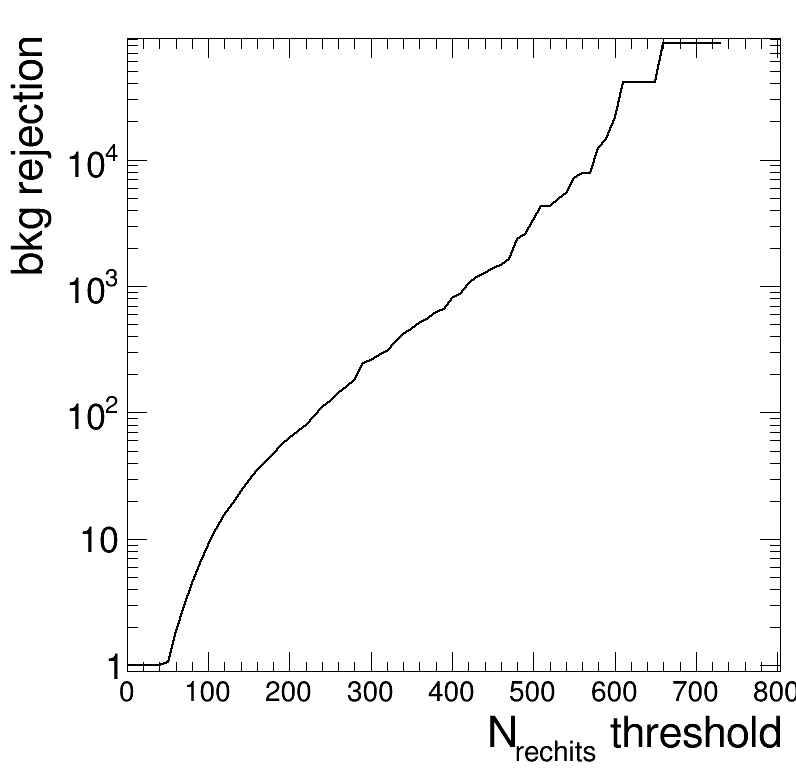

In [151]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.65,0.80,0.85,0.92)
# leg = rt.TLegend(0.35,0.80,0.55,0.92)

leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [met, nCsc_JetMuonVetoCluster0p4_Me1112Veto, bdt_score]
name = ['met', 'N_{rechits}', 'BDT score']
# legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'bkg'
sig_k = 'ggh18'
br = 0.02
h = {}
threshold = list(range(300))
threshold = np.array(list(range(200)))
# print(threshold)
for i in range(len(var)):
    if not i == 1:continue
    if i == 0: 
        bkg_k = 'qcd_bkg'
        threshold = np.arange(0,350, 18)

    else: 
        bkg_k = 'bkg'
        if i == 1: threshold = np.arange(0,2000, 10)
        else: threshold = np.arange(0,2001)/2000.
    eff = {}
    
    for k in [bkg_k, sig_k]:
        T = tree_bkg[k]
        weight_temp = T.array('weight')
        weight_sum = np.sum(weight_temp)
        met_temp = T.array('met')
        eff[k] = []
        for th in threshold:
            
            if i == 0: 
                
#                 eff[k].append(np.count_nonzero(var[i][k]>th)/len(var[i][k]))
                eff[k].append(np.sum(weight_temp[met_temp>th])/weight_sum)
            else: 
                eff[k].append(np.sum(weight[k][var[i][k]>th])/np.sum(weight[k]))
        
        eff[k] = np.array(eff[k])
#         if k == sig_k:
#             event_count[k] = event_count[k]*br
#     sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = np.logical_and(eff[bkg_k]>0, eff[sig_k] > 0.0003)
#     cond = eff[sig_k] > 0.0003

#     h[sig_k+str(i)] = create_TGraph(np.reciprocal(eff[bkg_k][cond]), eff[sig_k][cond],  axis_title=['bkg rejection', 'signal efficiency'])
    h[sig_k+str(i)] = create_TGraph(threshold[cond], np.reciprocal(eff[bkg_k][cond]),  axis_title=[name[i]+' threshold','bkg rejection'])
#     h[sig_k+str(i)] = create_TGraph(threshold[cond],eff[sig_k][cond],  axis_title=['threshold','signal efficiency'])

    print(eff[bkg_k][cond][-1])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[0])
    h[sig_k+str(i)].SetLineColor(std_color_list[0])
#     h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 30000000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)
#     h[sig_k+str(i)].SetMinimum(1)


    leg.AddEntry(h[sig_k+str(i)],name[i])
#     h[sig_k+str(i)].Draw('LA' if i == 0 else 'Lsame')
    h[sig_k+str(i)].Draw('LA')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')
#     c.SetLogx()
# leg.Draw()
c.SetLogy()
# c.SetLogx()
c.Draw()



# c.SetLogy()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# signal vs. bkg

0.6877377033233643


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


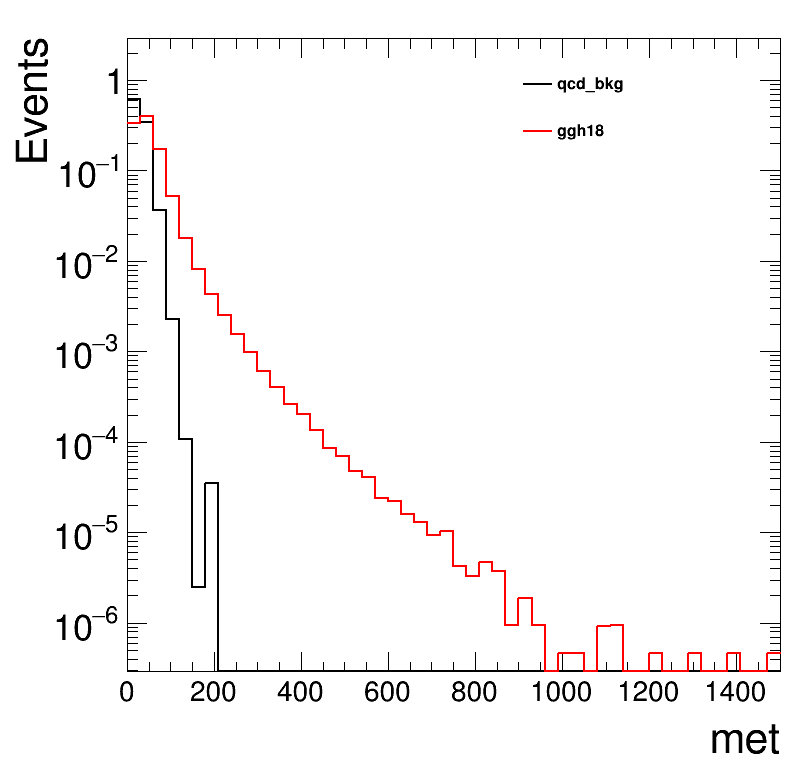

In [186]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.65,0.80,0.85,0.92)
# leg = rt.TLegend(0.35,0.80,0.55,0.92)

leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [met, nCsc_JetMuonVetoCluster0p4_Me1112Veto, bdt_score]
name = ['met', 'N_{rechits}', 'BDT score']
# legend = [ 'jet & muon veto + ME11/12 veto',]
bins = [[50,0,1500],[50,0,4000],[50,0,1]]
bkg_k = 'bkg'
sig_k = 'ggh18'
br = 0.02
h = {}
threshold = list(range(300))
threshold = np.array(list(range(200)))
# print(threshold)
for i in range(len(var)):
    if not i == 0:continue
    if i == 0: 
        bkg_k = 'qcd_bkg'
        threshold = np.arange(0,350, 18)

    else: 
        bkg_k = 'bkg'
    
    for j, k in enumerate([bkg_k, sig_k]):
        T = tree_bkg[k]
        if i == 0:
            h[k] = create_TH1D(T.array('met'), axis_title=[name[i], 'Events'], binning = bins[i], weights = T.array('weight'))
        else:
            h[k] = create_TH1D(var[i][k], axis_title=[name[i], 'Events'], binning = bins[i], weights =weight[k])


        h[k].SetLineWidth(2)
        h[k].SetMarkerColor(std_color_list[j])
        h[k].SetLineColor(std_color_list[j])
        h[k].GetXaxis().SetLabelSize(0.04)
        h[k].SetMinimum(1)
        h[k].SetMaximum(10000000)

        leg.AddEntry(h[k],k)
        h[k].DrawNormalized('hist same')

    #     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
    #     gr['bbbb'].Draw('')
    #     c.SetLogx()
    leg.Draw()
    c.SetLogy()
    # c.SetLogx()
    c.Draw()



# c.SetLogy()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# acceptance vs. ctau

In [94]:
eff[bkg_k]

array([1.0000000e+00, 6.9216716e-01, 2.6081198e-01, 6.6426814e-02,
       1.3116224e-02, 2.4361815e-03, 3.4828557e-04, 8.5106687e-05,
       3.9972820e-05, 3.7211645e-05, 3.6209523e-05, 3.5741734e-05,
       8.7631679e-07, 6.8128162e-07, 6.2490784e-07, 5.7929577e-07,
       3.5125146e-07, 3.1988876e-07, 3.0338666e-07, 2.8444398e-07,
       2.7792643e-07, 1.5329853e-07, 1.4153197e-07], dtype=float32)

# Efficiency vs. decay position

2173000 [ 16.700754 132.08536   20.725508 ...  20.198181  80.62169   23.800074]
ggh18 2932.9315053109895
ggh18 0.022379450355838843 1.1638196
ggh18 1336.9484 1.1638196
99575 [ 38.241188  89.06196   85.64807  ...  58.15522   69.47327  185.5338  ]
vbfh18 911.273709636589
vbfh18 0.006723486303604683 1.3465167
vbfh18 401.66107 1.3465167


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


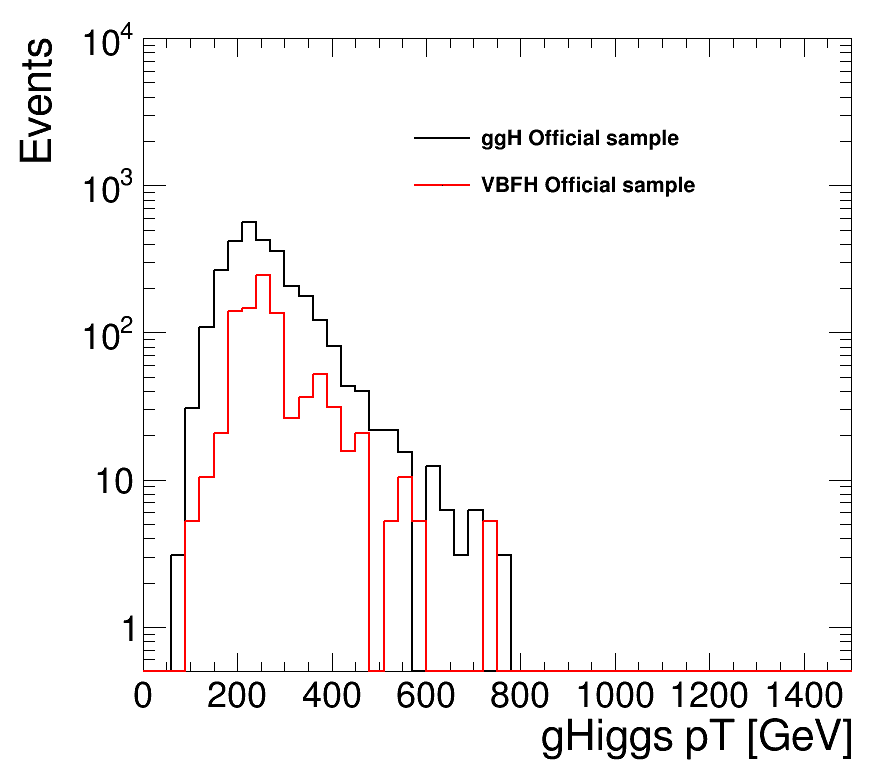

In [216]:

leg = rt.TLegend(0.45,0.73,0.80,0.85)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 900, 800)
# Plotting ncsc

rt.gStyle.SetOptFit(1011)
h = {}
k = 'ctau1'
bins = [50, 0, 3000]
# print(gLLP_decay_vertex_r)
# var = gHiggsPt[k] 
# bins = [50, 0, 500]
# name = 'gHiggs pT [GeV]'

# var = gLLP_pt[k] 
# bins = [50, 0, 500]
# name = 'gLLP pT [GeV]'

# var = met[k] 
# bins = [50, 0, 500]
# name = 'met [GeV]'
legend = {}
legend['ctau1'] = 'ggH Private sample, mx = 55GeV, Fall18'
legend['18'] = 'Official sample, mx = 55GeV, Fall18'
legend['17'] = 'Official sample, mx = 55GeV, Fall17'
legend['16'] = 'Official sample, mx = 55GeV, Summer16'

legend['ggh18'] = 'ggH Official sample'
legend['vbfh18'] = 'VBFH Official sample'


for i,k in enumerate(tree_bkg.keys()):
#     h[k] = create_TH1D(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['N_{rechits}', 'Events'], binning = [30,0,3000], weights =weight[k]*pileupWeight[k])
    cond = np.logical_and(np.sum(tree_bkg[k].array('gLLP_csc'), axis = 1) > 0, tree_bkg[k].array('met') > 200)
    cond = tree_bkg[k].array('met') >= 200
    print(len(cond), gHiggsPt[k])
#     h[k] = create_TH1D(gHiggsPt[k][cond], axis_title=['gHiggs pT [GeV]', 'Events'], binning = [30,0,1500], weights =weight_nocut[k][cond]*137000)
#     h[k] = create_TH1D(gHiggsPt[k][cond], axis_title=['gHiggs pT [GeV]', 'Events'], binning = [100,0,1500], weights =weight_nocut[k][cond]*137000)
    h[k] = create_TH1D(gHiggsPt[k][sel_ev[k]], axis_title=['gHiggs pT [GeV]', 'Events'], binning = [50,0,1500], weights =weight_nocut[k][sel_ev[k]]*137000)

#     print(weight_nocut[k][:100])
#     h[k] = create_TH1D(met[k], axis_title=['met [GeV]', 'Events'], binning = [30,0,1000], weights =weight[k]*pileupWeight[k])
#     h[k] = create_TH1D(tree_bkg[k].array('npu'), axis_title=['N_{rechits}', 'Events'], binning = [30,0,100],weights =weight_nocut[k]*tree_bkg[k].array('pileupWeight'))

#     h[k] = create_TH1D(tree_bkg[k].array('met'), axis_title=['met [GeV]', 'Events'], binning = [30,0,500],weights = tree_bkg[k].array('weight')*tree_bkg[k].array('pileupWeight'))
#     h[k] = create_TH1D(np.abs(tree_bkg[k].array('gHiggsEta')), axis_title=['gHiggs #eta', 'Events'], binning = [30,0,3.14],weights =weight_nocut[k]*tree_bkg[k].array('pileupWeight'))
#     h[k] = create_TH1D(tree_bkg[k].array('gLLP_ctau')[:,0], axis_title=['ctau', 'Events'], binning = [30,0,500],weights =tree_bkg[k].array('weight')*tree_bkg[k].array('pileupWeight'))

    
#     if k == 'ctau1':continue
#     h[k] = create_TH1D(dphiMet_cluster[k], axis_title=['N_{rechits}', 'Events'], binning = [30,0,3.14], weights =weight[k]*pileupWeight[k])
    h[k].SetLineColor(std_color_list[i])
    h[k].SetMaximum(10000)
    h[k].SetMinimum(0.5)
    print(k, h[k].Integral())
    h[k].Draw('same hist')
    leg.AddEntry(h[k],legend[k])
    w = weight[k]*pileupWeight[k]
    if '16' in k:
        lumi = 35.92 * 1000
    elif '17' in k:
        lumi = 41.53 * 1000
    else:
        lumi = 59.74 * 1000
    print(k, np.sum(w[nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])/lumi, w[0])
    print(k, np.sum(w[nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0]), w[0])
#     print(k, np.sum(w[nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=130]), w[0])
#     print(k, np.sum(weight_nocut[k][tree_bkg[k].array('met')>200]))
leg.Draw()

c.SetRightMargin(0.05)
c.SetLogz()
c.SetLogy()
# c.SetLogx()

c.Draw()


# gen level plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


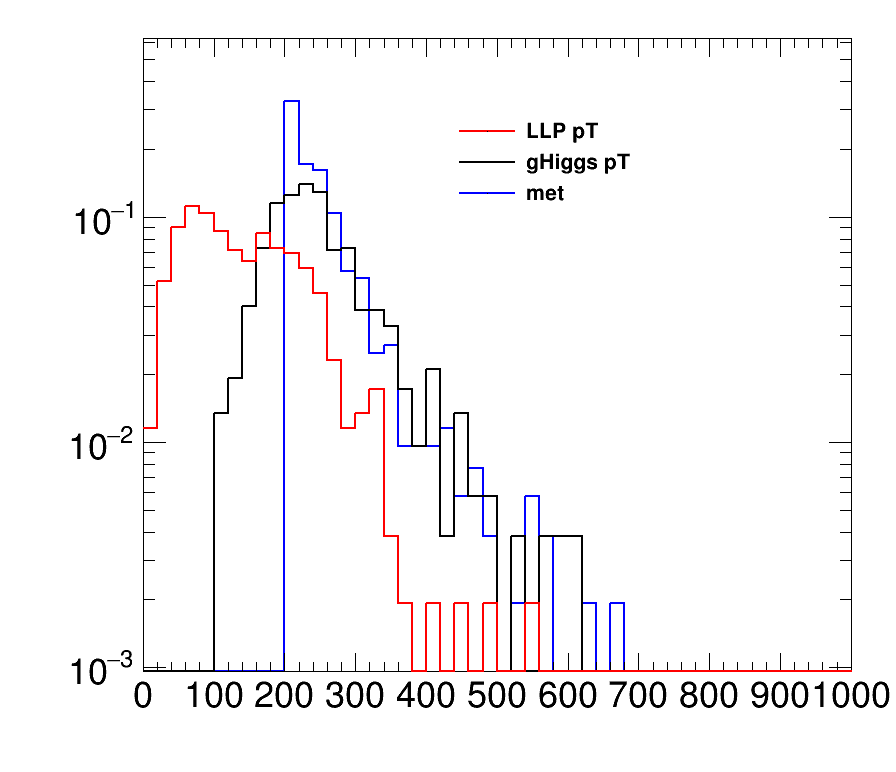

In [201]:

leg = rt.TLegend(0.5,0.73,0.85,0.85)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 900, 800)

rt.gStyle.SetOptFit(1011)
h = {}
k = 'ctau1'
bins = [50, 0, 1000]
# print(gLLP_decay_vertex_r)
cond = met[k]>200
h['gHiggsPt'] = create_TH1D(gHiggsPt[k][cond], binning = bins, weights = weight[k][cond])
h['llp_pt'] = create_TH1D(gLLP_pt[k].flatten()[cond], binning = bins, weights = weight[k][cond])
h['met'] = create_TH1D(met[k].flatten()[cond], binning = bins, weights = weight[k][cond])

# h['no_met'] = create_TH1D(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], binning = bins)

h['gHiggsPt'].SetLineColor(1)
h['llp_pt'].SetLineColor(2)
h['met'].SetLineColor(4)


h['met'].DrawNormalized('hist')
h['gHiggsPt'].DrawNormalized('samehist')
h['llp_pt'].DrawNormalized('samehist')
leg.AddEntry(h['llp_pt'], 'LLP pT ')
leg.AddEntry(h['gHiggsPt'], 'gHiggs pT ')
leg.AddEntry(h['met'], 'met ')

leg.Draw()

c.SetRightMargin(0.05)
c.SetLogz()
c.SetLogy()
# c.SetLogx()

c.Draw()


# Data plot

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'




keys = ['data_intime','data_oot','mc_signal',]
keys = ['data_intime','mc_signal',]


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(keys):

#     if k == 'data_intime':
#         cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 200
        
#     else:
#         cond = np.ones(weight[k].shape, dtype=bool)
#     cond = np.logical_and(cond, jetMet_dPhiMin4[k]>0.25)
    if k == 'mc_signal':
        br = 1
    else: br = 1
#     if k == 'mc_background':br = 1
    bins = [50,0,1000]
    metcut = 200
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = br*weight[k][cond])
    h[k].SetLineColor(std_color_list[i])
    print("weight",weight[k][0])
    leg.AddEntry(h[k], legend[k]+" (scaled)" if k == 'data_oot' else legend[k])
#     if k == 'mc_signal':
#         for i in range(h[k].GetNbinsX()):
#             s = 0.015*h[k].GetBinContent(i+1)
#             b = h['data_oot'].GetBinContent(i+1)
#             if s+b == 0:continue
#             sig = s/(s+b)**0.5
#             print(i,h[k].GetBinCenter(i+1),sig,s,b)
#             if sig < 1./100:
#                 print(i,sig)
#                 continue
#     h[k].SetMinimum(1)

#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].SetMinimum(0.1)
    h[k].SetMaximum(10E6/2)
#     h[k+'met'].GetXaxis().SetLabelSize(0.02)
    if k == 'data_oot':
        scale = 1.0*h['data_intime'].GetBinContent(4)/h['data_oot'].GetBinContent(4)
#         for i in range(10):
#             print(1.0*h['data_intime'].GetBinContent(i+1)/h['data_oot'].GetBinContent(i+1))
        h[k].Scale(scale)
    if k[:4] == 'data':
        h[k].Draw('same E1')
    else:
        h[k].Draw("same hist")
#     h[k+'met'].DrawNormalized('same')
    

# c = make_ratio_plot([h['mc'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()


k = 'data_intime'

h = {}
rt.gStyle.SetOptFit(1011)

bins = [40,0,1000]
metcut = 200

# cscRechitClusterMaxChamber = {}
# cscRechitClusterNChamber = {}
# cscRechitClusterNStation = {}
# cscRechitClusterMaxStationRatio = {}
# cscRechitClusterMaxChamberRatio = {}

# h[k] = create_TH1D( cscRechitClusterMaxChamber[k], axis_title=['max chamber', 'Events'], name=k, binning=[200,-50,50])
h[k] = create_TH1D( cscRechitClusterMaxChamberRatio[k], axis_title=['max chamber ratio', 'Events'], name=k, binning=[20,0,1])
# h[k] = create_TH1D( cscClusterMet_dPhi[k], axis_title=['#Delta#phi(MET, cluster)', 'Events'], name=k, binning=[20,0,3.14])
# h[k] = create_TH1D( n_chamber[k], axis_title=['Number of Chambers', 'Events'], name=k, binning=[10,0,10])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['max station', 'Events'], name=k, binning=[5,0,5])
# print(cscRechitClusterMaxStationRatio[k])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['Number of station', 'Events'], name=k, binning=[20,0,10])


# h['1jet'].GetXaxis().SetLabelSize(0.04)
# h['1jet'].SetMinimum(0.1)
# h['1jet'].SetMaximum(10E6/2)

h[k].Draw('hist')


c.SetRightMargin(0)
c.SetLogy()

c.Draw()
# print(time.time()-start_t)

## significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'data_oot'
sig_k = 'mc_signal'
br = 0.01

threshold = list(range(300))
threshold = np.array(list(range(2000)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in ['data_oot','mc_signal']:
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['N_{rechits}', 'Significnace'])
#     h[sig_k+str(i)] = create_TGraph(ncsc, event_count[sig_k],  axis_title=['N_{rechits}', 'Event Yield'])

    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 3000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# 2d plot

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin4[k])),
                   axis_title = ['N_{rechits}','min_{4jet}\Delta\phi (jet,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# third